In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [59]:
furniture_dir = os.path.join('../content/drive/MyDrive/train/furniture')
nameboard_dir = os.path.join('../content/drive/MyDrive/train/nameboard')
trafficsignal_dir = os.path.join('../content/drive/MyDrive/train/trafficsignal')

print('Total training furniture images:', len(os.listdir(furniture_dir)))
print('\nTotal training nameboard images:', len(os.listdir(nameboard_dir)))
print('\nTotal training trafficsignal images:', len(os.listdir(trafficsignal_dir)))

Total training furniture images: 244

Total training nameboard images: 300

Total training trafficsignal images: 200


In [60]:
furniture_files = os.listdir(furniture_dir)
print("Some furniture File Names\n", furniture_files[:5])

nameboard_files = os.listdir(nameboard_dir)
print("\nSome nameboard File Names\n",nameboard_files[:5])

trafficsignal_files = os.listdir(trafficsignal_dir)
print("\nSome trafficsignal File Names\n",trafficsignal_files[:5])

Some furniture File Names
 ['Barcelona-Chair-PNG-Image.png', 'Bean-Bag-Chair-PNG-Transparent-Image.png', 'Bench-PNG-Transparent-Image.png', 'Black-Sofa-PNG-Clipart.png', 'Antique-Chair-Background-PNG.png']

Some nameboard File Names
 ['4c5ef1a91b9cbd14cecaad7f379772fc.jpg', '5941_4180165918755_009e74dc_c4c8_4eb4_aeb0_39cd9a2eeb62.jpeg', '4c5ef1a91b9cbd14cecaad7f379772fc (1).jpg', '20211208_101136.jpg', '3c6e8612cdc9d38681eada84e2ae003e.jpg']

Some trafficsignal File Names
 ['photo-1581677641984-cf14ca58c5ee.jfif', 'photo-1584649525122-8d6895492a5d.jfif', 'photo-1538563188159-070c4db2bc65.jfif', 'photo-1587307293162-2fb7a3ebfc75.jfif', 'photo-1602913238167-3a810817d62a.jfif']


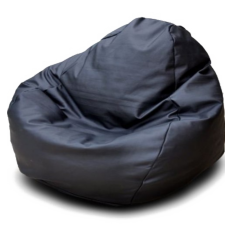

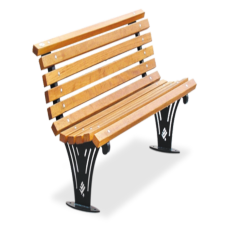

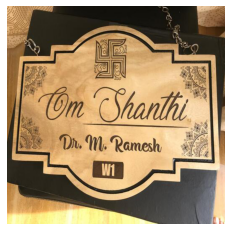

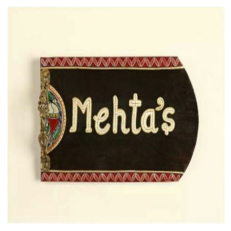

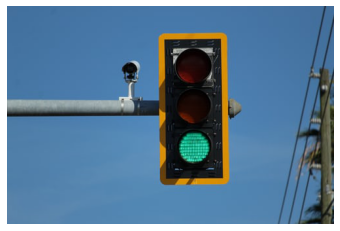

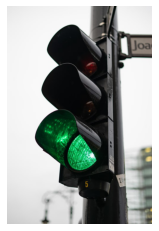

In [61]:
import matplotlib.image as mpimg

pic_index = 3

next_furniture = [os.path.join(furniture_dir, fname) 
                for fname in furniture_files[pic_index-2:pic_index]]
next_nameboard = [os.path.join(nameboard_dir, fname) 
                for fname in nameboard_files[pic_index-2:pic_index]]
next_trafficsignal = [os.path.join(trafficsignal_dir, fname) 
                for fname in trafficsignal_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_furniture+next_nameboard+next_trafficsignal):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

In [57]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
TRAINING_DIR = "../content/drive/MyDrive/train"
training_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

VALIDATION_DIR = "../content/drive/MyDrive/test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical',
  batch_size=100
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=50
)

Found 724 images belonging to 3 classes.
Found 301 images belonging to 3 classes.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

--2021-12-20 00:45:47--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.145.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  76.2MB/s    in 1.1s    

2021-12-20 00:45:48 (76.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [80]:
from tensorflow.keras.optimizers import RMSprop
adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)


x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (3, activation='softmax')(x)        

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 8,
            epochs = ,
            validation_steps = 7,
            verbose = 1)

Epoch 1/15
8/8 [==============================] - 58s 7s/step - loss: 0.3886 - accuracy: 0.9309 - val_loss: 0.8848 - val_accuracy: 0.9369
Epoch 2/15
8/8 [==============================] - 55s 7s/step - loss: 0.2045 - accuracy: 0.9738 - val_loss: 0.7246 - val_accuracy: 0.9402
Epoch 3/15
8/8 [==============================] - 57s 8s/step - loss: 0.0446 - accuracy: 0.9890 - val_loss: 0.4503 - val_accuracy: 0.9635
Epoch 4/15
8/8 [==============================] - 53s 7s/step - loss: 0.1642 - accuracy: 0.9751 - val_loss: 0.5876 - val_accuracy: 0.9502
Epoch 5/15
8/8 [==============================] - 54s 7s/step - loss: 0.1167 - accuracy: 0.9765 - val_loss: 0.6563 - val_accuracy: 0.9402
Epoch 6/15
8/8 [==============================] - 52s 6s/step - loss: 0.0879 - accuracy: 0.9834 - val_loss: 0.4057 - val_accuracy: 0.9668
Epoch 7/15
8/8 [==============================] - 57s 6s/step - loss: 0.0357 - accuracy: 0.9890 - val_loss: 0.4826 - val_accuracy: 0.9435
Epoch 8/15
8/8 [==================

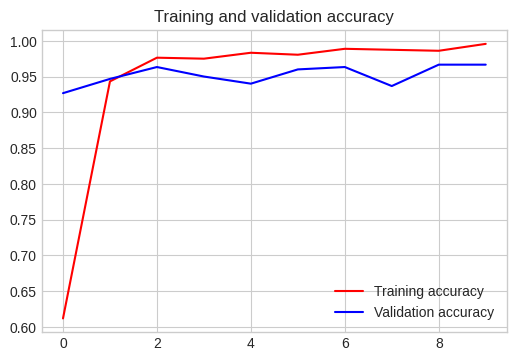

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.style.use('seaborn-whitegrid')
plt.figure(dpi = 100)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show();

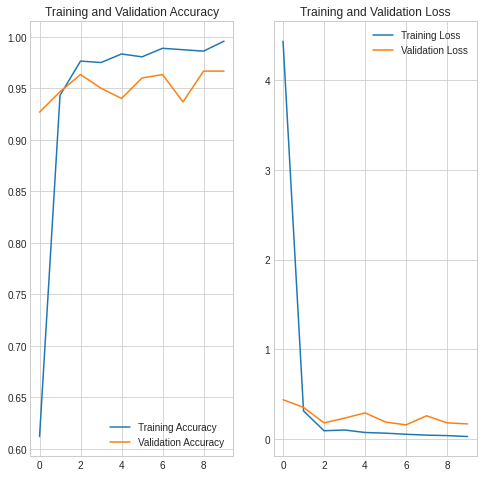

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
modelpath=TRAINING_DIR+"/E3.h5"
model.save(modelpath)

In [71]:
TRAINING_DIR = "../content/drive/MyDrive/train"

In [84]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tfliteModelPath=TRAINING_DIR+"/model.tflite"
with open(tfliteModelPath, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfebsnz_c/assets


INFO:tensorflow:Assets written to: /tmp/tmpfebsnz_c/assets
